# Pemodelan Sekuens dengan Neural Network
Pada bagian ini kita akan mencoba memprediksi sebuah sinyal sinusoidal dengan menggunakan model RNN. Setiap sampel sinyal akan diubah dalam bentuk empat buah fitur sekuensial berdasarkan masukan-masukan sebelumnya.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l

# Kode
## Membuat data masukan

- T = 1000 adalah jumlah data yang akan dibuat
- time = torch.arange(1, T + 1) adalah timeline waktu yang akan dibuat, mulai dari 1 sampai T
- x merupakan data yang dihasilkan dari fungsi torch.sin sesuai relasi berikut: x_i = sin(0.01 * time_i), dengan i = 1,2,...,T
- Kemudian, nilai x ditambahkan noise di setiap timeline waktu untuk memberikan tantangan pada model dengan menambahkan gaussian noise torch.normal dengan mean 0 dan standar deviasi 0.2

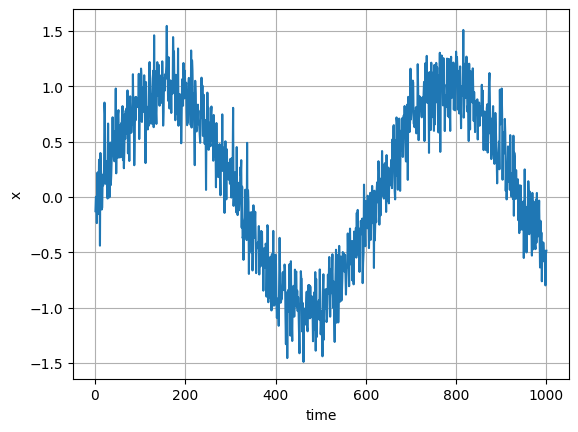

In [4]:
T       = 1000    # jumlah data
time    = torch.arange(1, T+1, dtype=torch.float32) # sumbu x berupa waktu
x       = torch.sin(0.01 * time)
x       = x + torch.normal(0, 0.2, (T,))

'''
mari kita coba plot data yang akan kita masukkan ke RNN. Untuk plot yang lebih singkat, dapat menggunakan perintah di bawah ini.
d2l.plot(X=time, Y=x, xlabel='time', ylabel='x', xlim=[1, T])
'''

plt.plot(time, x)
plt.xlabel('time')
plt.ylabel('x')
plt.grid()
plt.show()

Pada bagian selanjutnya, kita membuat feature dan labels yang akan digunakan untuk memprediksi fungsi sinus.


- Features adalah input x yang dipecah per setiap 4 data (lihat ilustrasi di bawah)
- labels adalah nilai output selanjutnya jika diberikan untaian urutan data features_i. Misalnya jika features_i = [a b c d] maka label nya adalah e. Begitu juga jika features_i = [c d e f] maka label nya adalah g

- https://github.com/mctosima/pengantarDLpytorch/blob/main/IPYNB%20Code/18_rnn_seq.ipynb

In [5]:
tau      = 4
features = torch.zeros((T - tau, tau))  # membuat matrix '0 sebanyak  996

print(range(tau))

range(0, 4)


In [7]:
for i in range(tau):    # dari 0 sampai 3
    features[:, i] = x[i:T - tau + i]

labels = x[tau:].reshape(-1,1)  # misal datanya adalah `a,b,c,d` maka label selanjutnya adalah `e`

print(f'Data yang di sintesis:',x[0:10])
print(f'Label:',labels[0:6])
print(f'Features:',features[0:6])

Data yang di sintesis: tensor([-0.1282,  0.0020,  0.0028, -0.2361,  0.2149,  0.2229, -0.1545,  0.0574,
         0.3367,  0.2616])
Label: tensor([[ 0.2149],
        [ 0.2229],
        [-0.1545],
        [ 0.0574],
        [ 0.3367],
        [ 0.2616]])
Features: tensor([[-0.1282,  0.0020,  0.0028, -0.2361],
        [ 0.0020,  0.0028, -0.2361,  0.2149],
        [ 0.0028, -0.2361,  0.2149,  0.2229],
        [-0.2361,  0.2149,  0.2229, -0.1545],
        [ 0.2149,  0.2229, -0.1545,  0.0574],
        [ 0.2229, -0.1545,  0.0574,  0.3367]])


# Dataset Dataloader
- batch_size = 16 adalah jumlah data yang akan dibuat dalam satu batch
- n_train = 600 adalah jumlah data yang akan digunakan untuk training (600 dari 1000)
- Fungsi TensorDataset dan DataLoader bersumber dari library torch.utils.data

In [8]:
batch_size       = 16
n_train          = 600 # banyaknya data yang digunakan untuk training

train_dataset    = TensorDataset(features[:n_train], labels[:n_train]) # 600 data pertama menjadi training data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Mendefinisikan model

Model sederhana (multi-layer-perceptron) yang kita gunakan terdiri dari tiga layer:

- Layer pertama adalah linear layer dengan masukan 4 dan keluaran 10. Mengapa 4? Karena feature yang kita miliki adalah 4 data.
- Layer kedua juga merupakan linear layer dengan masukan 10 dan keluaran 1. Mengapa 1 keluaran? Karena kita hanya ingin mengetahui sinus selanjutnya dari keempat masuka

Untuk loss yang kita gunakan adalah MSELoss

In [10]:
def simple_mlp():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    return net

criterion = nn.MSELoss()

# Melakukan Training
- Pada bagian ini kita akan melakukan iterasi untuk training.
- Optimizer yang kita gunakan adalah Adam dengan learning rate 0.01.
- Jumlah epoch yang digunakan adalah 5

In [11]:
def train(net, dataloader, criterion, epochs, lr):
    optimz = torch.optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for X, y in dataloader:
            
            output = net(X)
            loss = criterion(output, y)
            
            optimz.zero_grad()
            loss.backward()
            optimz.step()
            
        print(f'epoch {epoch + 1} loss: {loss.item():.4f}')
        
net = simple_mlp()
train(net, train_dataloader, criterion, 5, 0.01)

epoch 1 loss: 0.0459
epoch 2 loss: 0.0360
epoch 3 loss: 0.0546
epoch 4 loss: 0.1644
epoch 5 loss: 0.0872


# Melakukan Prediksi Satu Step
- Kita telah melakukan training dengan menggunakan 600 sampel data dan mencoba melakukan prediksi dari keseluruhan data.
- Untuk itu, kita akan memperbandingkan bentuk sinyal dari data yang kita prediksi dengan data asli (x)

Prediksi 1-step: tensor([[-0.0403],
        [ 0.0052],
        [ 0.0981],
        [ 0.0381],
        [ 0.1342],
        [ 0.1650]], grad_fn=<SliceBackward0>)
Label: tensor([[ 0.2149],
        [ 0.2229],
        [-0.1545],
        [ 0.0574],
        [ 0.3367],
        [ 0.2616]])
Features: tensor([[-0.1282,  0.0020,  0.0028, -0.2361],
        [ 0.0020,  0.0028, -0.2361,  0.2149],
        [ 0.0028, -0.2361,  0.2149,  0.2229],
        [-0.2361,  0.2149,  0.2229, -0.1545],
        [ 0.2149,  0.2229, -0.1545,  0.0574],
        [ 0.2229, -0.1545,  0.0574,  0.3367]])
Error: tensor(0.1825, grad_fn=<MeanBackward0>)


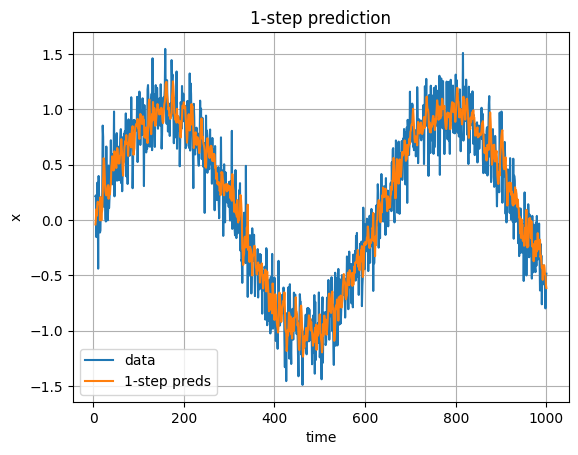

In [12]:
output_onestep = net(features)

plt.plot(time[tau:],x[tau:])
plt.plot(time[tau:],output_onestep.detach().numpy())
plt.xlabel('time')
plt.ylabel('x')
plt.title('1-step prediction')
plt.legend(['data', '1-step preds'])
plt.grid()

print(f'Prediksi 1-step:',output_onestep[0:6])
print(f'Label:',labels[0:6])
print(f'Features:',features[0:6])
print(f'Error:',(output_onestep - labels).abs().mean())

Jika eksperimen di atas berhasil dengan sempurna, bagaimana jika prediksi untuk setiap titik baru tidak dilakukan berdasarkan feature yang kita bentuk, melainkan hanya berdasarkan 4 data sebelumnya, dan data keluaran akan digunakan sebagai input untuk prediksi berikutnya?

# Multi-Step Prediction
Pertama-tama kita persiapkan dulu data masukan (sekaligus menjadi variabel keluaran dan digunakan menjadi input untuk prediksi berikutnya).

tensor([-0.1991, -0.1548, -0.2826,  0.0118,  0.0000,  0.0000])


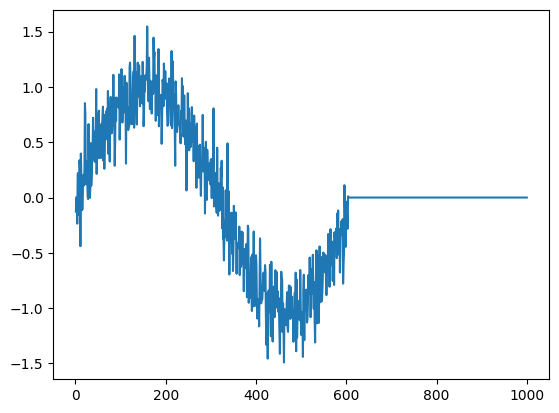

In [14]:
multistep_data = torch.zeros(T)                         # membuat array berisi '0' sebanyak 1000
multistep_data[: n_train + tau] = x[: n_train + tau]    # mengisi array multistep_data dengan data x dari index 0 hingga 603

print(multistep_data[600:606])                          # dapat diamati bahwa setelah index 603, data bernilai 0
plt.plot(time,multistep_data)

Setelah keluaran dicatat di variabel yang sama (dengan variabel masukan), keluaran tersebut digunakan untuk memprediksi nilai selanjutnya. Apa yang terjadi?

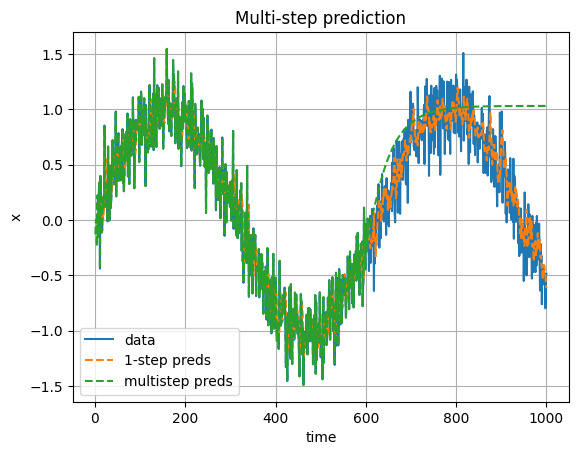

In [15]:
for i in range(n_train + tau, T):                                       # untuk setiap data yang kosong (index 604 hingga 999)
    multistep_data[i] = net(multistep_data[i - tau:i].reshape((1,-1))) # prediksi data yang kosong dengan menggunakan 4 data sebelumnya

plt.plot(time[tau:],x[tau:])
plt.plot(time[tau:],output_onestep.detach().numpy(),linestyle='--')
plt.plot(time,multistep_data.detach().numpy(),linestyle='dashed')
plt.xlabel('time')
plt.ylabel('x')
plt.title('Multi-step prediction')
plt.legend(['data', '1-step preds', 'multistep preds'])
plt.grid()

Yang terjadi adalah, model tidak mampu memprediksi nilai selanjutnya akibat error yang semakin menumpuk pada input berikutnya. Berbeda dengan 1-step prediction dimana setiap feature merupakan input yang benar untuk prediksi nilai berikutnya, pada percobaan ini, keluaran yang memiliki error akan digunakan sebagai inputan selanjutnya yang mana error tersebut akan semakin bertumpuk.

https://github.com/mctosima/pengantarDLpytorch/blob/main/IPYNB%20Code/18_rnn_seq.ipynb

Ukuran Features: torch.Size([933, 68])


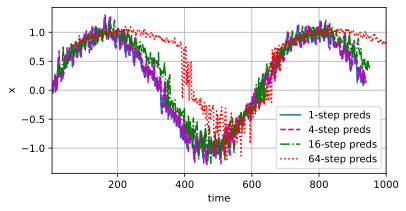

In [16]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

print(f'Ukuran Features:', features.shape)

for i in range(tau):            # dari 0 sampai 3
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)

'''
TODO : Harusnya bisa pakai matplotlib
'''
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

Dapat kita lihat pada hasil prediksi diatas bahwa masing-masing step menghasilkan nilai yang berbeda. Dengan 4-step data yang dihasilkan cukup baik namun tidak dengan step-step lainnya.